In [1]:
# Import pandas
import pandas as pd

# Import matplotlib and Basemap
import matplotlib.pyplot as plt  
from mpl_toolkits.basemap import Basemap  

%matplotlib inline



## Fun with Google location history

This notebook look at some location data provided by the [Google takeout](https://www.google.com/settings/takeout)
website. It was inspired and mostly copied from this 
[original post by Chris Albon](http://www.chrisalbon.com/map-your-google-location-history/).

### First look at the data

Having downloaded the `json` data to a file `LocationHistory.json` in the local
directory (or just amend the path below), we start by following Chris Albons post
and generating a first plot of the data. 

In [2]:
 # Create a dataframe from the json file in the filepath
raw = pd.io.json.read_json('LocationHistory.json') 
df = raw['locations'].apply(pd.Series) 

In [3]:
# Create a list from the latitude column, multiplied by -E7
df['latitude'] = df['latitudeE7'] * 1e-7

# Create a list from the longitude column, multiplied by -E7
df['longitude'] = df['longitudeE7'] * 1e-7

This defines some helper functions which plot all of the relevant data
in a data frame. This will be useful later on when we want to plot only
some subset, but not repeat the plotting commands. 

In [102]:
def PaddingFunction(xL, xR, frac=0.1):
    """ Return xL and xR with an added padding factor of frac either side """
    xRange = xR - xL
    xL_new = xL - frac*xRange
    xR_new = xR + frac*xRange
    return xL_new, xR_new

def GeneratePlot(data, c_list=None, s=20, alpha=0.5, fig=None):
    
    if type(data) == pd.core.frame.DataFrame:
        # Single df
        df = data
        df_list = [df]
    elif type(data) == list:
        df_list = data
        df = data[0]
        
    if not c_list:
        c_list = np.random.uniform(0, 1, (len(df_list), 3))
    
    if not fig:
        fig = plt.figure(figsize=(20,10))

    # Calculate some parameters which will be resused]
    lat_0 = df.latitude.mean()
    lon_0 = df.longitude.mean()
    llcrnrlon, urcrnrlon = PaddingFunction(df.longitude.min(), df.longitude.max(), frac=0.3)
    llcrnrlat, urcrnrlat = PaddingFunction(df.latitude.min(), df.latitude.max())

    # Create a map, using the Gall–Peters projection, 
    m = Basemap(projection='gall',  
                  resolution = 'l', 
                  area_thresh = 10000.0,
                  lat_0=lat_0, lon_0=lon_0,
                  llcrnrlon=llcrnrlon,
                  urcrnrlon=urcrnrlon,
                  llcrnrlat=llcrnrlat, 
                  urcrnrlat=urcrnrlat,
                  ax=fig.gca()
                  )

    m.drawcoastlines()
    m.drawcountries()
    m.fillcontinents(color = '#996633')
    m.drawmapboundary(fill_color='#0099FF')


    for df, c in zip(df_list, c_list):
        # Define our longitude and latitude points
        x, y = m(df['longitude'].values, df['latitude'].values)

        # Plot them using round markers of size 6
        m.scatter(x, y, c=c, s=s, alpha=alpha, zorder=100)

    return fig

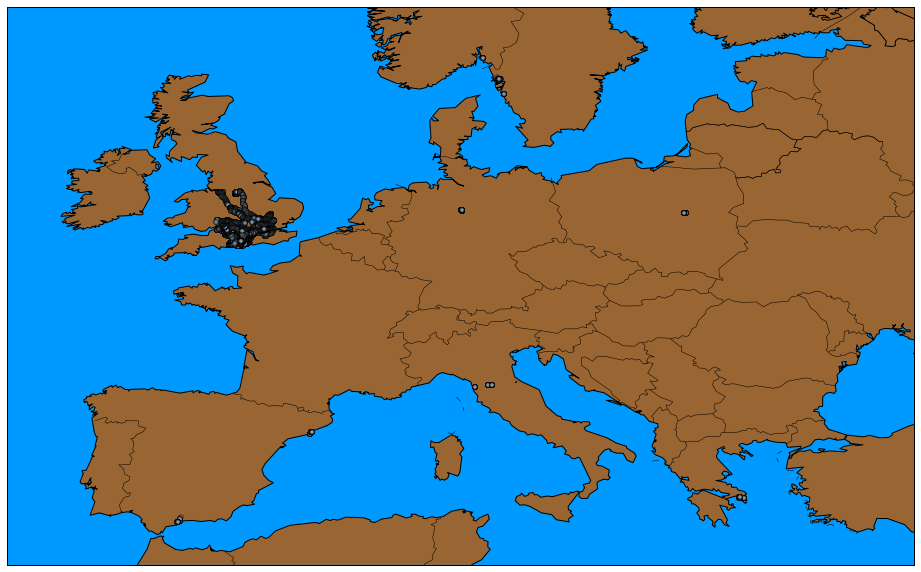

In [103]:
fig = GeneratePlot(df)

### Plotting local journeys to and from work

In [92]:
import Pycluster

data = np.array([df.latitude.values, df.longitude.values]).T
labels, error, nfound = Pycluster.kcluster(data, 10, method='a', dist='e', npass=10)
df['cluster_idx'] = labels

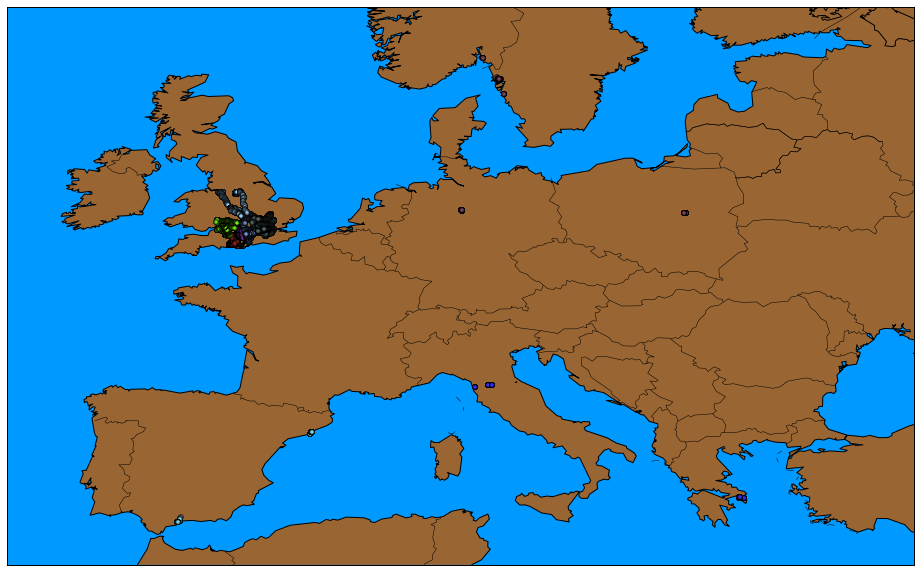

In [106]:
df_list = [df]
for idx in df.cluster_idx.unique():
    df_list.append(df[df.cluster_idx == idx])

fig = GeneratePlot(df_list)

In [59]:
from scipy.cluster.vq import kmeans, vq, whiten

data = np.array([df.latitude.values, df.longitude.values]).T
# computing K-Means with K = 2 (2 clusters)
centroids,_ = kmeans(data, 8, iter=10)
# assign each sample to a cluster
idx,_ = vq(data,centroids)

df['cluster_idx'] = idx

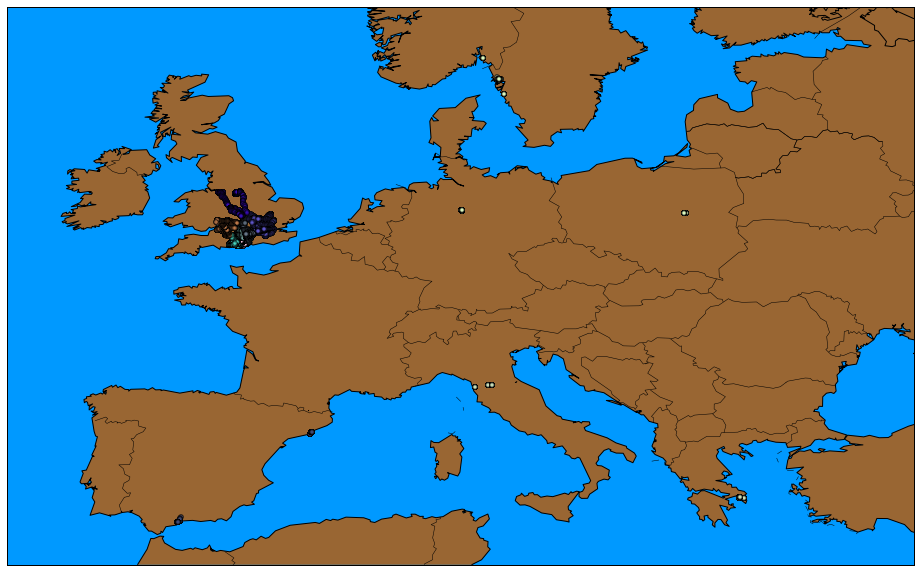

In [107]:
df_list = [df]
for idx in df.cluster_idx.unique():
    df_list.append(df[df.cluster_idx == idx])

fig = GeneratePlot(df_list)